In [1]:
import importlib
import pandas as pd
import numpy as np
import math
import copy
import itertools
import inspect # Used to inspect data generator arguments
from tqdm import tqdm 
import xarray as xr
from scipy.stats import genextreme
import re
import datetime
import matplotlib.pyplot as plt # Assumed installed for example plot
from scipy.spatial.distance import cdist
from GEV import * 
from utils import *

Data Generation functions : Independant GRID

In [2]:
def create_independent_gev_grid(loc, scale, shape,
                                num_x=5, num_y=5, num_t=5):
    """
    Generates an xarray.Dataset with independent GEV samples at each point.

    Each value in the grid (x, y, t) is drawn independently from the same
    GEV(loc, scale, shape) distribution.

    Args:
        loc (float): The location parameter (mu) of the GEV distribution.
        scale (float): The scale parameter (sigma > 0) of the GEV distribution.
        shape (float): The shape parameter (xi) of the GEV distribution.
                       Note: Internally uses c = -shape for scipy.stats.genextreme.
                       shape < 0 (c > 0) => Weibull type (bounded above)
                       shape = 0 (c = 0) => Gumbel type
                       shape > 0 (c < 0) => Fréchet type (heavy tail)
        num_x (int): Number of points along the x dimension. Default is 5.
        num_y (int): Number of points along the y dimension. Default is 5.
        num_t (int): Number of points along the t dimension. Default is 5.

    Returns:
        xarray.Dataset: An xarray Dataset with dimensions ('x', 'y', 't')
                        and a single data variable 'extreme_value' containing
                        independent GEV samples.

    Raises:
        ValueError: If the scale parameter is not positive.
    """
    # --- Input Validation ---
    if scale <= 0:
        raise ValueError("Scale parameter (sigma) must be positive.")

    # --- Define Coordinates ---
    x_coords = np.arange(num_x)
    y_coords = np.arange(num_y)
    t_coords = np.arange(num_t)

    # --- Generate GEV Data ---
    total_values = num_x * num_y * num_t
    # Generate independent samples using the specified parameters
    # Note: Using c = -shape consistent with user input convention
    gev_data_flat = genextreme.rvs(c=-shape, loc=loc, scale=scale, size=total_values)
    gev_data_3d = gev_data_flat.reshape(num_x, num_y, num_t)

    # --- Create xarray DataArray ---
    data_variable = xr.DataArray(
        data=gev_data_3d,
        coords={'lon': x_coords, 'lat': y_coords, 'time': t_coords},
        dims=['lon', 'lat', 'time'],
        name='extreme_value',
        attrs={
            'description': 'Independent synthetic data generated from a GEV distribution.',
            'units': 'unitless',
            'location': loc,
            'scale': scale,
            'shape': shape, # Store the input shape parameter (xi)
        }
    )
    # --- Create xarray Dataset ---
    dataset = xr.Dataset({'extreme_value': data_variable})
    dataset.attrs['creation_timestamp'] = datetime.datetime.now().isoformat()
    dataset.attrs['source'] = 'Generated by create_independent_gev_grid'
    dataset.attrs['grid_type'] = 'dimensionless integer coordinates'
    dataset.attrs['dependencies'] = 'Identically distributed, independent samples'

    return dataset

Data Generation functions : Dependant GRID

In [4]:
# Default values dictionary (can be centralized or defined per function)
TrendFunction = Callable[[np.ndarray, np.ndarray, np.ndarray], np.ndarray]
def generate_simple_trend_st(
    seed: int,
    params: Dict[str, Any]
) -> Tuple[TrendFunction, Tuple[float, float, float]]:
    """
    Generates a linear trend lambda: f(x,y,t) = intercept + coeff*spatial_var + t_coeff*t
    using parameters provided in a dictionary.

    Randomly selects a spatial variable ('x' or 'y'), coefficients for the
    spatial and temporal components, and an intercept, using ranges specified
    in the params dictionary.

    Args:
        seed (int): Seed for the random number generator.
        params (Dict[str, Any]): Dictionary containing the parameters needed:
            - 'coeff_range' (Tuple[float, float], optional): Min/max for spatial coeff.
            - 'intercept_range' (Tuple[float, float], optional): Min/max for intercept.
            - 't_coeff_range' (Tuple[float, float], optional): Min/max for time coeff.
            - 'variable_choice' (List[str], optional): Spatial variables ['x', 'y'].
            Defaults are used if keys are missing (see DEFAULT_TREND_PARAMS).

    Returns:
        Tuple containing:
        - TrendFunction: The lambda function calculating the trend.
        - Tuple[float, float, float]: The generated parameters (intercept, coeff, t_coeff).

    Raises:
        ValueError: If variable_choice is invalid or empty after lookup.
        KeyError: If essential parameter keys are missing and no defaults are set internally.
                  (Mitigated by using .get with defaults).
    """
    rng = np.random.default_rng(seed)

    # Extract parameters from dictionary, using defaults if missing
    coeff_range = params.get('coeff_range')
    intercept_range = params.get('intercept_range')
    t_coeff_range = params.get('t_coeff_range')
    variable_choice = params.get('variable_choice')

    if not variable_choice:
        raise ValueError("Parameter 'variable_choice' cannot be empty.")

    # 1. Choose spatial variable
    variable = rng.choice(variable_choice)
    if variable not in ['x', 'y']:
         raise ValueError(f"Invalid spatial variable '{variable}' found in 'variable_choice'. Must be 'x' or 'y'.")

    # 2. Sample coefficients and intercept
    coeff = rng.uniform(coeff_range[0], coeff_range[1])
    t_coeff = rng.uniform(t_coeff_range[0], t_coeff_range[1])
    intercept = rng.uniform(intercept_range[0], intercept_range[1])

    # 3. Construct lambda function (capturing values)
    # The lambda needs to handle grid inputs correctly
    if variable == 'x':
        # Ensure captured values (i, c, tc) are used inside lambda
        trend_func = lambda x_grid, y_grid, t_grid, i=intercept, c=coeff, tc=t_coeff: i + c * x_grid + tc * t_grid
    else: # variable == 'y'
        # Ensure captured values (i, c, tc) are used inside lambda
        trend_func = lambda x_grid, y_grid, t_grid, i=intercept, c=coeff, tc=t_coeff: i + c * y_grid + tc * t_grid

    # 4. Store parameters
    generated_params = (intercept, coeff, t_coeff)

    return trend_func, generated_params

def generate_complete_trend_st(
    seed: int,
    params: Dict[str, Any]
) -> Tuple[TrendFunction, Tuple[float, float, float, float]]:
    """
    Generates a complete linear trend function:
    f(x, y, t) = intercept + coeff_x * x + coeff_y * y + t_coeff * t
    using parameters provided in a dictionary.

    Samples coefficients for x, y, and temporal components, and an intercept,
    using ranges specified in the params dictionary.

    Args:
        seed (int): Seed for the random number generator.
        params (Dict[str, Any]): Dictionary containing the parameter ranges:
            - 'coeff_x_range' (Tuple[float, float]): Min/max for x coefficient.
            - 'coeff_y_range' (Tuple[float, float]): Min/max for y coefficient.
            - 'intercept_range' (Tuple[float, float]): Min/max for intercept.
            - 't_coeff_range' (Tuple[float, float]): Min/max for time coefficient.

    Returns:
        Tuple containing:
        - TrendFunction: The lambda function calculating the trend.
        - Tuple[float, float, float, float]: The generated parameters
          (intercept, coeff_x, coeff_y, t_coeff).

    Raises:
        KeyError: If any of the required range keys ('coeff_x_range',
                  'coeff_y_range', 'intercept_range', 't_coeff_range')
                  are missing from the params dictionary.
        TypeError: If the values associated with the range keys are not
                   subscriptable (e.g., None or not a tuple/list).
    """
    rng = np.random.default_rng(seed)

    # Extract parameters from dictionary. Using .get() provides a way to check
    # for missing keys explicitly for clearer error messages.
    coeff_x_range = params.get('coeff_x_range',(0, 0))
    coeff_y_range = params.get('coeff_y_range',(0, 0))
    intercept_range = params.get('intercept_range',(0, 0))
    t_coeff_range = params.get('t_coeff_range',(0, 0))

    # 1. Sample coefficients and intercept using the provided ranges
    # This assumes the ranges are valid tuples like (min, max)
    # A TypeError will occur here if the ranges are not subscriptable (e.g., None)
    coeff_x = rng.uniform(coeff_x_range[0], coeff_x_range[1])
    coeff_y = rng.uniform(coeff_y_range[0], coeff_y_range[1])
    t_coeff = rng.uniform(t_coeff_range[0], t_coeff_range[1])
    intercept = rng.uniform(intercept_range[0], intercept_range[1])

    # 2. Construct lambda function (capturing sampled values i, cx, cy, tc)
    # The lambda applies the complete linear trend formula to grid inputs
    trend_func: TrendFunction = lambda x_grid, y_grid, t_grid, i=intercept, cx=coeff_x, cy=coeff_y, tc=t_coeff: i + cx * x_grid + cy * y_grid + tc * t_grid

    # 3. Store all generated parameters
    generated_params = (intercept, coeff_x, coeff_y, t_coeff)

    # 4. Return the function and the parameters
    return trend_func, generated_params

# Example Usage (assuming you have a params dictionary defined):
# params_dict = {
#     'coeff_x_range': (-0.5, 0.5),
#     'coeff_y_range': (-0.3, 0.3),
#     'intercept_range': (10.0, 20.0),
#     't_coeff_range': (-0.05, 0.05)
# }
# trend_function, trend_params = generate_complete_trend_st(seed=42, params=params_dict)
# print(f"Generated trend parameters: {trend_params}")
# # You can then use trend_function(x_coords, y_coords, t_coords)

def generate_no_trend(
    seed: int,
    params: Dict[str, Any]
) -> Tuple[TrendFunction, Tuple[float, float, float]]:
    """
    Generates a constant trend lambda: f(x,y,t) = intercept
    using parameters provided in a dictionary.

    Samples an intercept from its range specified in the params dictionary.
    Spatial and temporal coefficients are fixed at zero.

    Args:
        seed (int): Seed for the random number generator.
        params (Dict[str, Any]): Dictionary containing the parameters needed:
             - 'intercept_range' (Tuple[float, float], optional): Min/max for intercept.
             Defaults are used if key is missing (see DEFAULT_TREND_PARAMS).

    Returns:
        Tuple containing:
        - TrendFunction: The lambda function returning a constant array.
        - Tuple[float, float, float]: The parameters (intercept, 0.0, 0.0).
    """
    rng = np.random.default_rng(seed)
    # Extract parameters from dictionary, using defaults if missing
    intercept_range = params.get('intercept_range')
    # 1. Sample intercept
    intercept = rng.uniform(intercept_range[0], intercept_range[1])

    # 2. Define zero coefficients
    coeff = 0.0
    t_coeff = 0.0

    # 3. Define the lambda function
    trend_func = lambda x_grid, y_grid, t_grid, i=intercept: np.full(
        x_grid.shape, fill_value=i, dtype=np.float64
    )

    # 4. Define the parameters tuple
    generated_params = (intercept, coeff, t_coeff)

    return trend_func, generated_params


# --- Main GEV Data Generation Function ---
def create_gev_nonstationary(
    loc: float = 0.0,
    scale: float = 1.0,
    shape: float = 0.0,
    trend_funcs: Optional[Dict[str, Optional[TrendFunction]]] = None,
    num_x: int = 50,
    num_y: int = 50,
    num_t: int = 5,
    seed: int = 0
) -> xr.Dataset:
    """
    Generates GEV data with potentially non-stationary location, scale, and shape parameters
    varying as functions of normalized spatial coordinates (x, y) and normalized time (t).

    This version accepts user-defined functions (including lambdas) for trends.

    Coordinates:
        - x: Runs from 0 to 1 along the 'lon' dimension.
        - y: Runs from 0 to 1 along the 'lat' dimension.
        - t: Runs from 0 to 1 along the 'time' dimension. (Normalized)

    Each parameter (loc, scale, shape) is calculated as:
    param(x, y, t) = base_param + trend_function(x, y, t)
    The `trend_function` is provided directly as a callable via the `trend_funcs` dictionary.
    If the corresponding key ('loc', 'scale', 'shape') is missing or its value is None
    in `trend_funcs`, the parameter is constant (base_param).

    **Trend Function Signature:**
    Any function provided must accept three arguments:
        1. x_grid (np.ndarray): Meshgrid of x coordinates [0,1] (shape: num_x, num_y, num_t).
        2. y_grid (np.ndarray): Meshgrid of y coordinates [0,1] (shape: num_x, num_y, num_t).
        3. t_grid (np.ndarray): Meshgrid of **normalized** t coordinates [0,1] (shape: num_x, num_y, num_t).
    It must return a numpy array of the same shape (num_x, num_y, num_t) representing
    the trend component to be added to the base parameter value.

    Args:
        loc (float): Base value for the location parameter (mu). Default is 0.0.
        scale (float): Base value for the scale parameter (sigma). Must be > 0 if no
                       scale trend function is provided. Default is 1.0.
        shape (float): Base value for the shape parameter (xi). Default is 0.0.
        trend_funcs (Dict[str, Optional[TrendFunction]], optional): Dictionary mapping
            parameter names ('loc', 'scale', 'shape') to optional callable functions
            that define the trend. Defaults to None (no trends).
            Example:
            {
                # Trend increases by 0.5 over the full normalized time period
                'loc': lambda x, y, t: 0.5 * t + 0.1 * x,
                'scale': my_scale_func # where my_scale_func is defined elsewhere
            }
        num_x (int): Number of points along the x dimension ('lon'). Default is 50.
        num_y (int): Number of points along the y dimension ('lat'). Default is 50.
        num_t (int): Number of points along the t dimension ('time'). Default is 5.
        seed (int): Seed for the random number generator used for GEV sampling. Default is 0.

    Returns:
        xarray.Dataset: An xarray Dataset containing GEV samples ('extreme_value')
                        and the calculated parameters ('location', 'scale', 'shape')
                        with potentially varying parameters. Base values and representations
                        of the trend functions used are stored as attributes.

    Raises:
        ValueError: If base scale <= 0 (and no trend func), if calculated scale <= 0,
                    or if a provided trend function returns an array of incorrect shape.
        TypeError: If an object provided in `trend_funcs` is not callable or does not
                   match the required signature.
        Exception: Any exception raised by the user-provided trend functions.
    ```
    """
    # Initialize trend_funcs if None
    if trend_funcs is None:
        trend_funcs = {}

    # Extract trend functions for validation and attribute storage
    loc_trend_func = trend_funcs.get('loc', None)
    scale_trend_func = trend_funcs.get('scale', None)
    shape_trend_func = trend_funcs.get('shape', None)

    # --- Basic Input Validation ---
    if scale_trend_func is None and scale <= 0:
        raise ValueError("Base scale parameter (sigma) must be positive if scale trend function is not provided.")

    # --- Define Coordinates (Normalized x, y, t) ---
    x_coords = np.linspace(0, 1, num_x)
    y_coords = np.linspace(0, 1, num_y)
    # *** MODIFIED: Use linspace for t to normalize between 0 and 1 ***
    t_coords = np.linspace(0, 1, num_t)
    expected_shape = (num_x, num_y, num_t)

    # --- Create meshgrids for x, y, t ---
    # Use 'ij' indexing so shape matches (num_x, num_y, num_t)
    # t_grid will now contain values between 0 and 1.
    x_grid, y_grid, t_grid = np.meshgrid(x_coords, y_coords, t_coords, indexing='ij')

    # --- Helper function to calculate a single parameter using a provided function ---
    def _calculate_parameter(param_name: str, base_value: float,
                             trend_func: Optional[TrendFunction],
                             x: np.ndarray, y: np.ndarray, t: np.ndarray) -> np.ndarray:
        """Calculates the parameter array by calling the trend function if provided."""

        if trend_func is None:
            # No trend, use constant base value
            return np.full(expected_shape, base_value, dtype=float)

        if not callable(trend_func):
            raise TypeError(f"Object provided for '{param_name}' trend is not callable (not a function or lambda).")

        try:
            # Call the user-provided function (passing normalized t_grid)
            trend_component = trend_func(x, y, t)

            # Validate the output shape
            if not isinstance(trend_component, np.ndarray) or trend_component.shape != expected_shape:
                 # Try broadcasting if scalar output is given
                 if np.isscalar(trend_component):
                     trend_component = np.full(expected_shape, trend_component, dtype=float)
                 else:
                    raise ValueError(f"Trend function for '{param_name}' returned an array with "
                                     f"shape {np.shape(trend_component)}, but expected {expected_shape}.")

        except TypeError as e:
            # Catch errors likely related to incorrect function signature
            raise TypeError(f"Error calling trend function for '{param_name}'. "
                            f"Ensure it accepts 3 arguments (x_grid, y_grid, t_grid). Original error: {e}") from e
        except Exception as e:
            # Re-raise any other exceptions from the user's function
            raise RuntimeError(f"Error executing trend function for '{param_name}'. Original error: {e}") from e

        # Add trend to the base value
        param_array = base_value + trend_component.astype(float) # Ensure float type

        return param_array

    # --- Calculate Spatially and Temporally Varying Parameters ---
    try:
        loc_xyt = _calculate_parameter('loc', loc, loc_trend_func, x_grid, y_grid, t_grid)
        scale_xyt = _calculate_parameter('scale', scale, scale_trend_func, x_grid, y_grid, t_grid)
        shape_xyt = _calculate_parameter('shape', shape, shape_trend_func, x_grid, y_grid, t_grid)
    except (ValueError, TypeError, RuntimeError) as e:
        # Re-raise calculation errors for clarity
        raise e
    except Exception as e:
        # Catch unexpected errors during calculation
        raise RuntimeError(f"An unexpected error occurred during parameter calculation: {e}") from e


    # --- Validate Calculated Scale Parameter ---
    if np.any(scale_xyt <= 0):
        min_scale = np.min(scale_xyt)
        raise ValueError(f"Calculated scale parameter must be positive everywhere, but found "
                         f"minimum value {min_scale:.4f}. Check base 'scale' ({scale}) and "
                         f"the 'scale' trend function: {scale_trend_func!r}.") # Use repr for function

    # --- Generate GEV Data ---
    # Use the calculated parameter arrays. Note: scipy.stats.genextreme uses c = -shape.
    gev_data_3d = genextreme.rvs(c=-shape_xyt, loc=loc_xyt, scale=scale_xyt,
                                 size=expected_shape)

    # --- Create xarray DataArrays for parameters and data ---
    # Use the normalized t_coords for the time dimension
    coords_dict = {'lon': x_coords, 'lat': y_coords, 'time': t_coords}
    dims_list = ['lon', 'lat', 'time']

    # Helper to get a string representation of the function for attributes
    def func_repr(func):
        if func is None:
            return 'None'
        try:
            # Use repr for better info, especially for named functions
            return repr(func)
        except Exception:
            return str(func) # Fallback

    data_var = xr.DataArray(
        data=gev_data_3d,
        coords=coords_dict,
        dims=dims_list,
        name='extreme_value',
        attrs={
            'description': 'Synthetic GEV samples.',
            'units': 'unitless'
        }
    )
    loc_var = xr.DataArray(
        data=loc_xyt, coords=coords_dict, dims=dims_list, name='location',
        attrs={'description': 'GEV location parameter (mu)', 'base_value': loc, 'trend_function': func_repr(loc_trend_func)}
    )
    scale_var = xr.DataArray(
        data=scale_xyt, coords=coords_dict, dims=dims_list, name='scale',
         attrs={'description': 'GEV scale parameter (sigma)', 'base_value': scale, 'trend_function': func_repr(scale_trend_func)}
    )
    shape_var = xr.DataArray(
        data=shape_xyt, coords=coords_dict, dims=dims_list, name='shape',
        attrs={'description': 'GEV shape parameter (xi)', 'base_value': shape, 'trend_function': func_repr(shape_trend_func)}
    )

    # --- Create xarray Dataset ---
    dataset = xr.Dataset({
        'extreme_value': data_var,
        'location': loc_var,
        'scale': scale_var,
        'shape': shape_var
        })

    dataset.attrs['creation_timestamp'] = datetime.datetime.now(datetime.timezone.utc).isoformat()
    dataset.attrs['source'] = 'Generated by create_gev_nonstationary_lambda'
    # *** MODIFIED: Update grid_type attribute ***
    dataset.attrs['grid_type'] = 'normalized spatial and temporal coordinates (0-1)'
    dataset.attrs['dependencies'] = 'Spatio-temporal dependence via user-provided functions for loc, scale, and shape.'
    # Store the input trend function dictionary representation for reference
    dataset.attrs['input_trend_funcs'] = str({k: func_repr(v) for k, v in trend_funcs.items()})

    return dataset

print("\n--- Example 2: Lambda Trends (Normalized Time) ---")
trends = {
    'loc': lambda x, y, t: 10 * t + 100*x        
}
ds_trends = create_gev_nonstationary(
    loc=10, scale=2, shape=0.1, trend_funcs=trends, num_x=30, num_y=30, num_t=100, seed=42
)



--- Example 2: Lambda Trends (Normalized Time) ---


Data visualization functions

In [5]:
def plot_time(
    data: Union[xr.Dataset, xr.DataArray],
    lon_index: int = 0,
    lat_index: int = 0,
    var_name: Optional[str] = 'extreme_value',
    lon_dim: str = 'lon', # Added dimension name args
    lat_dim: str = 'lat',
    time_dim: str = 'time'
) -> None:
    """
    Plots the time series for a specific spatial point in the xarray data.

    Args:
        data: The dataset or data array containing the variable to plot.
              Must have dimensions corresponding to lon_dim, lat_dim, time_dim.
        lon_index: The integer index for the longitude dimension.
        lat_index: The integer index for the latitude dimension.
        var_name: The name of the variable to plot if 'data' is a Dataset.
                  If 'data' is a DataArray, this is used for labeling unless None.
                  Defaults to 'extreme_value'.
        lon_dim: Name of the longitude dimension (default: 'lon').
        lat_dim: Name of the latitude dimension (default: 'lat').
        time_dim: Name of the time dimension (default: 'time').
    """
    da = None
    actual_var_name = None

    # --- Extract DataArray ---
    if isinstance(data, xr.Dataset):
        if var_name is None:
             print(f"Error: var_name must be specified when providing a Dataset.")
             return
        if var_name not in data:
            print(f"Error: Dataset does not contain variable '{var_name}'. "
                  f"Available variables: {list(data.data_vars.keys())}")
            return
        da = data[var_name]
        actual_var_name = var_name
    elif isinstance(data, xr.DataArray):
        da = data
        actual_var_name = data.name or var_name or "Data" # Use DA name, fallback to arg or default
    else:
        print("Error: Input 'data' must be an xarray Dataset or DataArray.")
        return

    # --- Validate Dimensions ---
    required_dims = {lon_dim, lat_dim, time_dim}
    if not required_dims.issubset(da.dims):
         print(f"Error: DataArray '{actual_var_name}' is missing one or more required dimensions: "
               f"{required_dims}. Found dimensions: {da.dims}")
         return

    try:
        # --- Select Data Point ---
        # Select the data point using integer indices based on provided dim names
        selection_indices = {lon_dim: lon_index, lat_dim: lat_index}
        selected_point_data = da.isel(**selection_indices)

        # --- Create Plot ---
        plt.figure(figsize=(10, 5))
        selected_point_data.plot.line(marker='.', linestyle='-') # Use xarray's plotting

        # --- Customize Plot ---
        # Attempt to get coordinate values for title, fallback if coords missing
        try:
             lon_val_str = f"{selected_point_data[lon_dim].item():.2f}"
        except:
             lon_val_str = f"index {lon_index}" # Fallback if coord missing/not scalar

        try:
             lat_val_str = f"{selected_point_data[lat_dim].item():.2f}"
        except:
             lat_val_str = f"index {lat_index}" # Fallback

        plt.title(f"Time Series for '{actual_var_name}'\nat {lon_dim}={lon_val_str}, {lat_dim}={lat_val_str}")
        plt.xlabel(f"Time ({time_dim})")
        plt.ylabel(actual_var_name)
        plt.grid(True, alpha=0.5)
        plt.tight_layout()
        plt.show()

    except IndexError:
        print(f"Error: Indices {lon_dim}={lon_index}, {lat_dim}={lat_index} are out of bounds "
              f"for data with shape {da.shape}. Check dimensions: {da.dims}.")
    except Exception as e:
        print(f"An error occurred during time series plotting: {e}")


def plot_map(
    data: Union[xr.Dataset, xr.DataArray],
    t_index: int = 0,
    var_name: Optional[str] = 'extreme_value',
    lon_dim: str = 'lon', # Added dimension name args
    lat_dim: str = 'lat',
    time_dim: str = 'time'
) -> None:
    """
    Plots a 2D spatial map (image) of the data at a specific time index 't'.

    Args:
        data: The dataset or data array containing the variable to plot.
              Must have dimensions corresponding to lon_dim, lat_dim, time_dim.
        t_index: The integer index for the time dimension.
        var_name: The name of the variable to plot if 'data' is a Dataset.
                  If 'data' is a DataArray, this is used for labeling unless None.
                  Defaults to 'extreme_value'.
        lon_dim: Name of the longitude dimension (default: 'lon').
        lat_dim: Name of the latitude dimension (default: 'lat').
        time_dim: Name of the time dimension (default: 'time').
    """
    da = None
    actual_var_name = None

    # --- Extract DataArray ---
    if isinstance(data, xr.Dataset):
        if var_name is None:
             print(f"Error: var_name must be specified when providing a Dataset.")
             return
        if var_name not in data:
            print(f"Error: Dataset does not contain variable '{var_name}'. "
                  f"Available variables: {list(data.data_vars.keys())}")
            return
        da = data[var_name]
        actual_var_name = var_name
    elif isinstance(data, xr.DataArray):
        da = data
        actual_var_name = data.name or var_name or "Data"
    else:
        print("Error: Input 'data' must be an xarray Dataset or DataArray.")
        return

    # --- Validate Dimensions ---
    required_dims = {lon_dim, lat_dim, time_dim}
    if not required_dims.issubset(da.dims):
         print(f"Error: DataArray '{actual_var_name}' is missing one or more required dimensions: "
               f"{required_dims}. Found dimensions: {da.dims}")
         return

    try:
        # --- Select Time Slice ---
        selection_indices = {time_dim: t_index}
        selected_time_slice = da.isel(**selection_indices)

        # --- Create Plot ---
        plt.figure(figsize=(8, 7)) # Adjusted size slightly
        # Ensure plot uses correct x,y dimensions based on args
        selected_time_slice.plot.imshow(
            x=lon_dim, y=lat_dim, cmap='viridis', robust=True # robust handles outliers in color scale
        )

        # --- Customize Plot ---
        # Attempt to get time coordinate value for title
        try:
             time_val_str = f"{selected_time_slice[time_dim].item()}"
             # Try formatting nicely if it's datetime-like
             if np.issubdtype(selected_time_slice[time_dim].dtype, np.datetime64):
                  # Convert numpy datetime64 to something more readable if possible
                  try:
                       time_val_str = str(selected_time_slice[time_dim].dt.round('s').item()) # Round to nearest second
                  except: pass # Keep original if conversion fails
             elif np.issubdtype(selected_time_slice[time_dim].dtype, np.timedelta64):
                  try:
                       time_val_str = str(selected_time_slice[time_dim].dt.round('s').item())
                  except: pass
        except:
             time_val_str = f"index {t_index}" # Fallback

        plt.title(f"Spatial Map for '{actual_var_name}'\nat {time_dim} = {time_val_str}")
        # Labels are usually handled well by xarray based on coordinates
        # plt.xlabel(f"{lon_dim}") # Usually set automatically
        # plt.ylabel(f"{lat_dim}") # Usually set automatically
        plt.tight_layout()
        plt.show()

    except IndexError:
        print(f"Error: Time index {time_dim}={t_index} is out of bounds "
              f"for data with time dimension size {da.dims[time_dim]}.")
    except Exception as e:
        print(f"An error occurred during spatial map plotting: {e}")


Data Generation

Fitting

In [6]:
def reconstruct_xarray_from_flat(
    prediction_params_flat: np.ndarray, 
    mdt: Dict[str, Any],
    original_ds: xr.Dataset
) -> xr.Dataset:
    """
    Reconstructs an xarray Dataset with GEV parameters (loc, scale, shape)
    from a flattened prediction array (parameters, time, space).

    Assumes the input array corresponds to loc, scale, shape in order along
    the first dimension.
    Reverses the flattening performed by xarray_to_endog_exog
    (which uses stack(space=('lat', 'lon'))).

    Args:
        prediction_params_flat: The 3D NumPy array prediction with shape
                                (3, T, S) for [loc, scale, shape], where
                                S = N_lat * N_lon.
        mdt: Metadata dictionary containing 't', 'n_lat', 'n_lon', 's'.
        original_ds: The original xarray Dataset from which the data was
                     flattened. Used to retrieve coordinates and ensure consistency.

    Returns:
        An xarray Dataset containing three data variables ('prediction_loc',
        'prediction_scale', 'prediction_shape'), each with dimensions
        ('lon', 'lat', 'time').

    Raises:
        ValueError: If shapes or metadata are inconsistent.
        TypeError: If prediction_params_flat is not a NumPy array.
    """
    # 1. Extract Dimensions from metadata
    try:
        T = mdt['t']
        N_lat = mdt['n_lat']
        N_lon = mdt['n_lon']
        S = mdt['s'] # Total spatial points
    except KeyError as e:
        raise ValueError(f"Metadata dictionary 'mdt' is missing required key: {e}")

    # --- Simplified Input Validation ---
    if not isinstance(prediction_params_flat, np.ndarray):
        raise TypeError("prediction_params_flat must be a NumPy array.")

    expected_shape_3d = (3, T, S)
    if prediction_params_flat.shape != expected_shape_3d:
            # Check if S in metadata was inconsistent but dims otherwise match
            if prediction_params_flat.shape[0] == 3 and \
               prediction_params_flat.shape[1] == T and \
               prediction_params_flat.shape[2] == N_lat * N_lon:
                 warnings.warn(f"Metadata inconsistency: mdt['s'] ({S}) != N_lat ({N_lat}) * N_lon ({N_lon}). "
                               f"Input array shape ({prediction_params_flat.shape}) matches (3, T, N_lat*N_lon). "
                               f"Proceeding by correcting S.", UserWarning)
                 S = N_lat * N_lon # Correct S based on dims
            else:
                 # Shape mismatch is real
                 raise ValueError(f"Input NumPy array prediction_params_flat has incorrect shape {prediction_params_flat.shape}. "
                                  f"Expected {expected_shape_3d} based on metadata (parameters, time, space).")
    # --- End Input Validation ---


    # 3. Get Coordinates from original dataset
    try:
        lon_coord_name = 'lon'
        lat_coord_name = 'lat'
        time_coord_name = 'time'

        lon_coords = original_ds[lon_coord_name]
        lat_coords = original_ds[lat_coord_name]
        time_coords = original_ds[time_coord_name]

        # Verify coordinate lengths match metadata dimensions
        if len(lon_coords) != N_lon:
            raise ValueError(f"Original dataset '{lon_coord_name}' coord length ({len(lon_coords)}) "
                             f"doesn't match metadata n_lon ({N_lon})")
        if len(lat_coords) != N_lat:
            raise ValueError(f"Original dataset '{lat_coord_name}' coord length ({len(lat_coords)}) "
                             f"doesn't match metadata n_lat ({N_lat})")
        if len(time_coords) != T:
             if len(time_coords) < T :
                  raise ValueError(f"Original dataset '{time_coord_name}' coord length ({len(time_coords)}) "
                             f"is less than metadata T ({T})")
             elif len(time_coords) > T:
                  warnings.warn(f"Original dataset '{time_coord_name}' coord length ({len(time_coords)}) "
                             f"is greater than metadata T ({T}). Using the first {T} time coordinates.", UserWarning)
                  time_coords = time_coords[:T]

    except KeyError as e:
        raise ValueError(f"Original dataset 'original_ds' is missing expected coordinate: {e}")

    # --- Reconstruct each parameter ---
    reconstructed_params = {}
    param_names = ['prediction_loc', 'prediction_scale', 'prediction_shape']

    for i, param_name in enumerate(param_names):
        # Extract the flattened data for this parameter: shape (T, S)
        param_flat = prediction_params_flat[i, :, :]

        # 4. Transpose and Reshape
        # Input shape (T, S) -> Transpose to (S, T)
        # Reshape S (where lon varied fastest) back to (N_lat, N_lon)
        # Resulting shape before final transpose: (N_lat, N_lon, T)
        try:
            reshaped_data_lat_lon_time = param_flat.T.reshape((N_lat, N_lon, T))
        except ValueError as e:
            raise ValueError(f"Reshaping failed for parameter '{param_name}' (to N_lat, N_lon, T). "
                             f"Check consistency. Original error: {e}")

        # 5. Create intermediate DataArray with (lat, lon, time) order
        param_da_intermediate = xr.DataArray(
            data=reshaped_data_lat_lon_time,
            coords=[lat_coords, lon_coords, time_coords],
            dims=[lat_coord_name, lon_coord_name, time_coord_name],
            name=param_name
        )

        # 6. Transpose to final desired order ('lon', 'lat', 'time')
        param_da_final = param_da_intermediate.transpose(lon_coord_name, lat_coord_name, time_coord_name)

        reconstructed_params[param_name] = param_da_final

    # 7. Create final Dataset
    reconstructed_ds = xr.Dataset(reconstructed_params)

    return reconstructed_ds

Bias, Variance, MSE

In [15]:
def calculate_parameter_metrics(
    fit_ds: xr.Dataset,
    ground_truth_ds: xr.Dataset,
    param_mapping: Dict[str, Dict[str, str]] = {
        'location': {'fit': 'prediction_loc', 'true': 'location'},
        'scale': {'fit': 'prediction_scale', 'true': 'scale'},
        'shape': {'fit': 'prediction_shape', 'true': 'shape'}
    }
) -> Dict[str, Dict[str, float]]:
    """
    Calculates Bias, Variance (of the estimate), and MSE for fitted GEV
    parameters compared against true parameters.

    MSE is calculated using the formula: MSE = Bias² + Variance(Estimate).

    Args:
        fit_ds: Dataset containing the fitted parameters (e.g., 'prediction_loc').
        ground_truth_ds: Dataset containing the true parameters (e.g., 'location').
        param_mapping: Dictionary mapping canonical parameter names (keys) to
                       a dictionary containing the variable names for the 'fit'
                       and 'true' parameters in the respective datasets.

    Returns:
        A dictionary where keys are the canonical parameter names ('location',
        'scale', 'shape') and values are dictionaries containing the calculated
        scalar metrics ('bias', 'variance', 'mse') for that parameter.

    Raises:
        ValueError: If required variables are missing, datasets are incompatible,
                    or alignment/filtering results in no valid data points.
        KeyError: If parameter names or 'fit'/'true' keys in mapping are invalid.
    """
    results = {}
    # Define a small epsilon for checks if needed, though not used in this version
    # EPSILON = 1e-9

    for param_name, mapping in param_mapping.items():
        # --- Check mapping and variables exist ---
        if 'fit' not in mapping or 'true' not in mapping:
             raise KeyError(f"Mapping for '{param_name}' must contain 'fit' and 'true' keys.")
        fit_var_name = mapping['fit']
        true_var_name = mapping['true']

        if fit_var_name not in fit_ds:
            raise KeyError(f"Fitted variable '{fit_var_name}' (for {param_name}) not found in fit_ds.")
        if true_var_name not in ground_truth_ds:
            raise KeyError(f"True variable '{true_var_name}' (for {param_name}) not found in ground_truth_ds.")

        fit_da = fit_ds[fit_var_name]
        true_da = ground_truth_ds[true_var_name]

        # --- Align Data and Handle NaNs ---
        try:
            fit_aligned, true_aligned = xr.align(fit_da, true_da, join="inner")

            # Ensure float type
            fit_aligned = fit_aligned.astype(float)
            true_aligned = true_aligned.astype(float)

            # Create a mask for valid, non-NaN pairs
            valid_mask = np.isfinite(fit_aligned) & np.isfinite(true_aligned)
            if not valid_mask.any():
                raise ValueError(f"Alignment/filtering resulted in zero valid overlapping points for parameter '{param_name}'. Check coordinates and NaNs.")

            # Apply mask for calculations - use .where to keep original shape but mask invalid points
            fit_masked = fit_aligned.where(valid_mask)
            true_masked = true_aligned.where(valid_mask)
            error_masked = fit_masked - true_masked # Error calculated only on valid points

        except Exception as e:
            raise ValueError(f"Failed to align or process parameters '{fit_var_name}' and '{true_var_name}'. Check dimensions and coordinates. Original error: {e}")

        # --- Calculate Metrics (operating on masked data) ---
        # Use skipna=True which is default for xarray ops like mean/var on masked arrays
        bias = float(error_masked.mean(skipna=True).item())

        # Calculate Variance of the *Estimate* (fitted parameter)
        # Use the masked fitted values
        variance = float(error_masked.var(skipna=True).item())

        # Check if calculations resulted in NaN (can happen if all values were masked)
        if np.isnan(bias) or np.isnan(variance):
              results[param_name] = {'bias': np.nan, 'variance': np.nan, 'mse': np.nan}
              warnings.warn(f"Bias or Variance calculation resulted in NaN for parameter '{param_name}'. Check input data for all NaNs after alignment.")
              continue # Skip to the next parameter

        # Calculate MSE using the Bias-Variance decomposition formula
        mse = variance + bias**2

        # --- Store Results ---
        results[param_name] = {
            'bias': bias,
            'variance': variance, # Variance of the estimate
            'sd':  np.sqrt(variance), # Variance of the estimate
            'mse': mse,
            'rmse' : np.sqrt(mse)
        }


    return results

BIG SIM 

1] Trend in X

In [8]:
def run_simulation_raw(
    sim_config: Dict[str, Any],
    show_progress: bool = True,
    marginal: bool = False # <<< Added marginal flag
) -> Tuple[Dict[str, np.ndarray], List[str]]:
    """
    Runs a flexible Monte Carlo simulation scenario and returns RAW metrics.

    This function uses a configuration dictionary to set up and run the
    simulation, allowing for independently configured trends for location,
    scale, and shape parameters via `sim_config['trend_config']`. It fits a
    pre-defined GEV model either jointly across all locations or marginally
    (independently for each location) and returns raw metrics for each
    successful run.

    Args:
        sim_config (Dict[str, Any]): Dictionary containing ALL parameters needed:
            - 'trend_config': (Dict[str, Dict]) Nested dictionary structuring
                              trend generation for 'location', 'scale', 'shape'.
                              Each sub-dict contains:
                                - 'generator_func': Callable generator function or None.
                                - 'params': Dict of parameters for the generator func.
            - 'base_location', 'base_scale', 'base_shape': Base GEV values.
            - 'res', 'num_t': Data dimensions (res implies sqrt(num_s)).
            - 'num_simulations': Number of runs.
            - 'metrics_to_track', 'gev_params_order': Metric/output control.
            - 'random_seed_base': Seed offset.
            - 'endog_var', 'include_time_coords', 'include_space_coords': Flattening.
            - 'fit_method', 'gev_param_exog_map', 'start_params',
              'apply_start_noise', 'start_params_noise_std': Fitting setup.
        show_progress (bool): If True, display a tqdm progress bar.
        marginal (bool): If False (default), fits the GEV model jointly using
                         all spatial locations and covariates.
                         If True, fits the GEV model marginally for each spatial
                         location independently, using only the first covariate
                         (index 0 from the original exog) for parameters specified
                         in 'gev_param_exog_map'. `start_params` are ignored
                         in marginal fitting.

    Returns:
        Tuple: (results_dict, gev_params_order)
            - results_dict (Dict[str, np.ndarray]): {metric: array(n_successful_runs, n_params)}
            - gev_params_order (List[str]): Order of GEV params in arrays.

    Raises:
        KeyError: If essential parameters are missing from sim_config.
        TypeError: If generator functions are not callable.
        ValueError: If parameter values are inconsistent or marginal fitting fails.
    """
    # --- Extract essential parameters from config ---
    try:
        # Simulation Control
        num_simulations = sim_config['num_simulations']
        random_seed_base = sim_config.get('seed', 0) # Renamed from 'random_seed_base' for clarity
        metrics_to_track = sim_config['metrics_to_track']
        gev_params_order = sim_config['gev_params_order'] # Crucial for output interpretation
        num_gev_params = len(gev_params_order)

        # Trend Generation Config (Structure validated later)
        trend_config = sim_config.get('trend_config', {}) # Default to empty dict

        # Base GEV Params (Needed by create_gev_nonstationary)
        base_location = sim_config['base_location']
        base_scale = sim_config['base_scale']
        base_shape = sim_config['base_shape']

        # Data Creation Params
        res = sim_config['res'] # Assumes num_s = res * res
        num_t = sim_config['num_t']

        # Flattening Params
        endog_var = sim_config.get('endog_var', 'extreme_value')
        include_time_coords = sim_config.get('include_time_coords', True)
        include_space_coords = sim_config.get('include_space_coords', True)

        # Fitting Params
        fit_method = sim_config['fit_method']
        start_params_config = sim_config.get('start_params', None) # List or None
        apply_start_noise = sim_config.get('apply_start_noise', False)
        start_params_noise_std = sim_config.get('start_params_noise_std', 0.1)
        gev_param_exog_map = sim_config['gev_param_exog_map'] # Dict {gev_param: bool}

    except KeyError as e:
        raise KeyError(f"Essential parameter '{e}' missing from sim_config dictionary.") from e

    # --- Initialize collectors ---
    raw_results_collector = {metric: [] for metric in metrics_to_track}
    num_successful_runs = 0
    rng = np.random.default_rng() # RNG for start_params noise

    iterable = range(num_simulations)
    # Use a generic description as the generator might change per param
    fit_type = "Marginal" if marginal else "Joint"
    desc = f"Sim ({fit_type}, res={res})"
    if show_progress:
        iterable = tqdm(iterable, desc=desc)

    # --- Simulation Loop ---
    for i in iterable:
        current_seed = random_seed_base + i
        # Initialize metrics storage for this run with NaNs
        run_metrics_array = {metric: np.full(num_gev_params, np.nan) for metric in metrics_to_track}

        try:
            # 1. Generate Trend Functions (for loc, scale, shape) based on config
            trend_funcs = {} # Dictionary to pass to create_gev_nonstationary
            # Map internal GEV param names to keys used by create_gev_nonstationary
            gev_param_key_map = {'location': 'loc', 'scale': 'scale', 'shape': 'shape'}

            for j, gev_param_name in enumerate(gev_params_order): # Iterate 'location', 'scale', 'shape'
                param_trend_config = trend_config.get(gev_param_name)
                trend_lambda = None # Default to no trend for this parameter

                if isinstance(param_trend_config, dict):
                    generator_func = param_trend_config.get('generator_func')
                    generator_params = param_trend_config.get('params', {}) # Default to empty params dict

                    if callable(generator_func):
                        try:
                            # Call the specific generator for this GEV parameter
                            # Assuming generator returns (lambda_func, debug_info)
                            trend_lambda, _ = generator_func(
                                seed=current_seed + j, # Offset seed slightly per parameter trend
                                params=generator_params
                            )
                        except Exception as gen_e:
                            warnings.warn(f"Error calling generator '{getattr(generator_func, '__name__', 'unknown')}' for '{gev_param_name}' in run {i+1}: {gen_e}. Using base value.")
                            trend_lambda = None # Fallback to base value on generator error
                    elif generator_func is not None:
                        warnings.warn(f"Invalid 'generator_func' for '{gev_param_name}' (not callable). Using base value.")
                        trend_lambda = None # Ensure it's None if not callable

                # Store the generated lambda (or None) in the dict for create_gev_nonstationary
                create_key = gev_param_key_map.get(gev_param_name)
                if create_key:
                    trend_funcs[create_key] = trend_lambda
                # else: Handle potential mismatch between gev_params_order and map keys? (Currently ignored)

            # 2. Generate Ground Truth Dataset (passing potentially multiple trends)
            gev_ds = create_gev_nonstationary(
                loc=base_location, # Pass base values
                scale=base_scale,
                shape=base_shape,
                trend_funcs=trend_funcs, # Pass the dict of generated lambdas/None
                num_x=res, num_y=res, num_t=num_t,
                # Pass seed if create_gev_nonstationary uses it for sampling
                # seed=current_seed # Assuming it might be needed for GEV sampling randomness
            )
            # plot_time(gev_ds) # Optional plotting

            # 3. Flatten Data for Fitting
            endog, exog, mdt = xarray_to_endog_exog(
                ds = gev_ds[endog_var].to_dataset(), # Ensure ds is Dataset-like
                endog_var=endog_var,
                include_time_coords=include_time_coords,
                include_space_coords=include_space_coords
            )
            # Get dimensions after flattening
            current_num_t = endog.shape[0]
            num_s = endog.shape[1] # Number of spatial locations/series
            # num_c = exog.shape[1] # Original number of covariates

            # --- 4. Fit Model (Jointly or Marginally) ---
            prediction_params_flat: Optional[np.ndarray] = None # Initialize

            if not marginal:
                # --- 4a. JOINT Fitting ---
                # Prepare Exog Dictionary for JOINT Fit
                exog_fit_dict = {
                    gev_param: exog
                    for gev_param, use_exog in gev_param_exog_map.items()
                    if use_exog
                }

                # Prepare Start Params for JOINT Fit
                start_params_final = None
                if start_params_config:
                    # Ensure it's a list before applying noise
                    start_params_final = list(start_params_config)
                    if apply_start_noise:
                        noise_vals = rng.normal(0, start_params_noise_std, size=len(start_params_final))
                        start_params_final = [p + n for p, n in zip(start_params_final, noise_vals)]
                        # Optional: Add heuristics like ensuring scale positivity if needed

                # Fit Model JOINTLY
                fitter = GEVSample(endog=endog, exog=exog_fit_dict)
                afit = fitter.fit(fit_method=fit_method, start_params=start_params_final)

                # Get JOINT fitted parameters (List of arrays (T,S)) -> Stack to (num_gev_params, T, S)
                prediction_params_flat = np.stack(afit.gev_params, axis=0)

            else:
                # --- 4b. MARGINAL Fitting ---
                all_marginal_params_s = [] # To collect params from each site fit (num_gev_params, T, 1)

                # Loop through each spatial location (site)
                for s_i in range(num_s):
                    # Extract data for site s_i, keeping dimensions for GEVSample
                    endog_s = endog[:, s_i:s_i+1] # Shape (T, 1)
                    # Select ONLY the first covariate (index 0) for this site
                    # Keep dimensions: Shape (T, 1, 1)
                    if exog.shape[1] > 0: # Check if there are any covariates
                         exog_s = exog[:, 0:1, s_i:s_i+1]
                    else: # Handle case where original exog might be empty or have no covariates
                         exog_s = np.empty((current_num_t, 0, 1)) # Shape (T, 0, 1) - No covariates

                    # Prepare Exog Dictionary for MARGINAL Fit
                    # Use exog_s (the single selected covariate) for any GEV param needing exog
                    exog_fit_dict_s = {}
                    if exog_s.shape[1] > 0: # Only add if we actually selected a covariate
                        exog_fit_dict_s = {
                            gev_param: exog_s
                            for gev_param, use_exog in gev_param_exog_map.items()
                            if use_exog
                        }

                    # Fit Model MARGINALLY for site s_i
                    # NOTE: Using start_params=None for marginal fit.
                    fitter_s = GEVSample(endog=endog_s, exog=exog_fit_dict_s)
                    try:
                        afit_s = fitter_s.fit(fit_method=fit_method, start_params=None) # Pass None for start_params
                        # Get fitted parameters for site s_i (List of (T,1)) -> Stack to (num_gev_params, T, 1)
                        params_s = np.stack(afit_s.gev_params, axis=0)
                        all_marginal_params_s.append(params_s)
                    except Exception as fit_err:
                         warnings.warn(f"Marginal fit failed for site {s_i} in run {i+1}: {fit_err}. Skipping site.")
                         # Need to append NaNs or handle missing site later during concatenation?
                         # For now, we just skip. Concatenation might fail if list is empty.

                # Concatenate parameters from all successful sites along the spatial dimension (axis=2)
                if all_marginal_params_s:
                    prediction_params_flat = np.concatenate(all_marginal_params_s, axis=2) # Shape (num_gev_params, T, S_successful)
                    # If some sites failed, the S dimension might be smaller than original num_s.
                    # reconstruct_xarray_from_flat needs to handle this or we need to pad with NaNs.
                    # Assuming reconstruct can handle it or expecting all sites to succeed for now.
                    if prediction_params_flat.shape[2] != num_s:
                         warnings.warn(f"Run {i+1}: Marginal fitting succeeded for {prediction_params_flat.shape[2]}/{num_s} sites. Result shape might mismatch expectations.")
                         # How to proceed? Option 1: Raise error. Option 2: Pad with NaN (complex). Option 3: Continue with partial result.
                         # Let's raise an error for now if the shape doesn't match, as reconstruction might fail.
                         raise ValueError(f"Run {i+1}: Marginal fitting did not succeed for all sites ({prediction_params_flat.shape[2]}/{num_s}). Cannot proceed with reconstruction.")

                else:
                     # Handle case where num_s = 0 or all marginal fits failed
                     raise ValueError(f"Run {i+1}: Marginal fitting failed for all sites or num_s is 0.")


            # --- 5. Reconstruct Fitted Dataset ---
            # This step requires prediction_params_flat to be successfully created
            fit_ds = reconstruct_xarray_from_flat(
                prediction_params_flat=prediction_params_flat, # Use the result from if/else
                mdt=mdt,
                original_ds=gev_ds # Pass original structure for reconstruction
            )

            # --- 6. Calculate & Store Metrics ---
            parameter_metrics = calculate_parameter_metrics(ground_truth_ds=gev_ds, fit_ds=fit_ds)

            # Store the calculated metrics for this run
            for metric in metrics_to_track:
                for idx, param_name in enumerate(gev_params_order):
                    if param_name in parameter_metrics and metric in parameter_metrics[param_name]:
                        run_metrics_array[metric][idx] = parameter_metrics[param_name][metric]
                    # else: Metric not found for this param, leave as NaN

            # Append the metrics array for this successful run to the collector
            for metric in metrics_to_track:
                raw_results_collector[metric].append(run_metrics_array[metric])
            num_successful_runs += 1

        except Exception as e:
            warnings.warn(f"Error in run {i+1} (Seed={current_seed}, res={res}, Fit={fit_type}): {e}. Skipping run.")
            # Optionally add traceback print here for debugging
            # import traceback; traceback.print_exc()
            # Ensure metrics for this run are not added if an error occurred before appending
            continue # Skip to the next simulation run

    # --- Convert collected lists to final numpy arrays ---
    final_results_dict = {}
    if num_successful_runs > 0:
        for metric in metrics_to_track:
            # Check if list is not empty before stacking
            if raw_results_collector[metric]:
                final_results_dict[metric] = np.stack(raw_results_collector[metric], axis=0) # Shape (n_successful_runs, n_params)
            else:
                # Should not happen if num_successful_runs > 0, but as fallback:
                final_results_dict[metric] = np.empty((0, num_gev_params))
    # Ensure all requested metrics have an entry, even if empty
    for metric in metrics_to_track:
        if metric not in final_results_dict:
             final_results_dict[metric] = np.empty((0, num_gev_params)) # Shape (0, n_params)

    if num_successful_runs < num_simulations:
         warnings.warn(f"Completed {num_successful_runs}/{num_simulations} simulation runs successfully.")

    # Return results and the parameter order used
    return final_results_dict, gev_params_order

def aggregate_simulation_results(
    raw_results_dict: Dict[str, np.ndarray],
    gev_params_order: List[str],
    aggregation_func: Callable = np.mean
) -> Dict[str, np.ndarray]:
    """
    Aggregates raw simulation results over the runs dimension.

    Args:
        raw_results_dict: Dictionary where keys are metric names and values are
                          numpy arrays of shape (num_successful_runs, num_gev_params)
                          containing raw metric values.
        gev_params_order: The list defining the order of the last dimension
                          in the arrays within raw_results_dict.
        aggregation_func: The numpy function used to aggregate across the
                          simulation runs (axis=0). Default: np.nanmean.

    Returns:
        Dict[str, np.ndarray]: Dictionary where keys are metric names and
                               values are numpy arrays of shape (num_gev_params,)
                               containing the aggregated metric value for each
                               GEV parameter. Returns an empty dict if input is empty.
    """
    aggregated_metrics = {}
    if not raw_results_dict:
        return aggregated_metrics # Return empty if no raw results

    num_gev_params = len(gev_params_order)

    for metric, raw_array in raw_results_dict.items():
        if raw_array.ndim == 2 and raw_array.shape[1] == num_gev_params and raw_array.size > 0:
            # Aggregate over runs (axis=0), result is shape (n_params,)
            try:
                aggregated_metrics[metric] = aggregation_func(raw_array, axis=0)
            except Exception as e:
                 warnings.warn(f"Failed to aggregate metric '{metric}' with function '{aggregation_func.__name__}': {e}. Skipping metric.")
                 aggregated_metrics[metric] = np.full(num_gev_params, np.nan) # Fill with NaN on failure
        elif raw_array.ndim == 1 and raw_array.shape[0] == num_gev_params and raw_array.size >0 :
             # Handle case where input might already be aggregated (e.g. only 1 simulation run)
             # Or if input structure was different than expected.
             # For now, assume if 1D, it's already aggregated or represents a single run.
             # If it's a single run, aggregation might change its meaning, let's just pass it through
             # or raise a warning. Passing through might be unexpected. Let's warn and NaN fill.
              warnings.warn(f"Input array for metric '{metric}' is 1D. Aggregation function expects axis 0. Returning NaNs.")
              aggregated_metrics[metric] = np.full(num_gev_params, np.nan)
        else:
            # Handle empty arrays or shape mismatches
            warnings.warn(f"Skipping metric '{metric}' due to unexpected shape {raw_array.shape} or empty array.")
            aggregated_metrics[metric] = np.full(num_gev_params, np.nan) # Fill with NaN

    return aggregated_metrics


# Define the configuration, now with the 'trend_config' structure
sim_config_multi = {
    # --- Simulation Control & Basic Params ---
    'num_simulations': 1, 'seed': 500,
    'metrics_to_track': ['bias', 'variance','rmse'],
    'gev_params_order': ['location', 'scale', 'shape'],
    'res': 1, 'num_t': 5,
    # --- Base GEV Params ---
    'base_location': 0, # Base value if trend func returns 0 or is None
    'base_scale': 1,
    'base_shape': 0.1,
    # --- Trend Generation Config ---
    'trend_config': {
        'location': {
            'generator_func': generate_complete_trend_st,
            'params': {'intercept_range': (50, 50), 't_coeff_range' : (1,1)}
        },
        'scale': {
        'generator_func': generate_complete_trend_st,
        'params': {'intercept_range': (10, 10), 't_coeff_range' : (1,1)}
        },
    },
    # --- Flattening Config ---
    'endog_var': 'extreme_value', 'include_time_coords': True, 'include_space_coords': False,
    # --- Fitting Config ---
    'fit_method': 'MLE',
    'gev_param_exog_map': {'location': True, 'scale': True, 'shape': False}, # Fit trend only for loc
    'apply_start_noise': False, 'start_params_noise_std': 0.1
}

print("--- Running Global Simulation (Multi-Trend Config) ---")
# Call the updated function

raw_results, gev_order = run_simulation_raw(
    sim_config=sim_config_multi,
    show_progress=True,
    marginal=False
)

print("\n--- Simulation Finished ---")
if raw_results and 'bias' in raw_results and raw_results['bias'].size > 0:
    num_success = raw_results['bias'].shape[0]
    print(f"Number of successful runs: {num_success}")
    print(f"Returned GEV parameter order: {gev_order}")
    print(f"Shape of 'rmse' results: {raw_results.get('rmse', np.array([])).shape}")

    # --- Optional: Aggregate and Format ---
    try:
        # Assume aggregate_simulation_results & format_aggregated_results_to_df exist
        agg_results = aggregate_simulation_results(raw_results, gev_order)
    except NameError:
        print("\n(Skipping aggregation display: Helper functions not defined)")
    except ImportError:
        print("\n(Skipping aggregation formatting: pandas not installed)")
else:
    print("Simulation produced no results.")

--- Running Global Simulation (Multi-Trend Config) ---


Sim (Joint, res=1):   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\paulusr\AppData\Local\Temp\ipykernel_7760\3855644417.py:271: UserWarning: Error in run 1 (Seed=500, res=1, Fit=Joint): ('Optim issues can often stem from bad automatic starting parameters.\n  Suggestion: Verify your `start_params` and/or provide manual initial guesses (especially intercepts) in the start_params attribute of the fit method.', <class 'RuntimeWarning'>). Skipping run.
  warnings.warn(f"Error in run {i+1} (Seed={current_seed}, res={res}, Fit={fit_type}): {e}. Skipping run.")
Sim (Joint, res=1): 100%|██████████| 1/1 [00:00<00:00, 22.32it/s]


--- Simulation Finished ---
Simulation produced no results.



C:\Users\paulusr\AppData\Local\Temp\ipykernel_7760\3855644417.py:293: UserWarning: Completed 0/1 simulation runs successfully.
  warnings.warn(f"Completed {num_successful_runs}/{num_simulations} simulation runs successfully.")


In [9]:
def run_simulation_sweep_agg(
    sim_func_raw: Callable, # e.g., run_simulation_raw (needs adaptation)
    param_sweep_config: Dict[str, List[Any]], # Params to vary
    base_sim_config: Dict[str, Any], # Base config with new structure
    aggregation_func: Callable = np.nanmean,
    show_sweep_progress: bool = True,
    show_inner_progress: bool = False,
    marginal = False
) -> xr.Dataset:
    """
    Runs simulation sweeps, supporting separate trend configs per GEV param.

    Assumes `sim_func_raw` uses a `sim_config` containing a 'trend_config'
    dictionary specifying generator functions and parameters for 'location',
    'scale', and 'shape' independently.

    Args:
        sim_func_raw (Callable): The global simulation function adapted for the
            new config structure. Expected signature:
            `(sim_config, show_progress) -> Tuple[Dict, List]`.
            Note: data_generator_func is now implicitly defined within sim_config.
        param_sweep_config (Dict[str, List[Any]]): Dictionary defining parameters
            within `base_sim_config` to vary and their values. Can target nested
            keys (e.g., within trend_config params).
        base_sim_config (Dict[str, Any]): The base configuration dictionary,
            expected to contain a 'trend_config' key structuring the trend generation.
        aggregation_func (Callable): Aggregation function (e.g., np.nanmean).
        show_sweep_progress (bool): Show progress bar for the sweep loop.
        show_inner_progress (bool): Show progress bar for inner simulation loop.

    Returns:
        xr.Dataset: Aggregated simulation results.
    """
    sweep_param_names = list(param_sweep_config.keys())
    sweep_param_values_lists = list(param_sweep_config.values())
    param_combinations = list(itertools.product(*sweep_param_values_lists))

    aggregated_results_store = {}
    gev_params_order = None
    all_metrics_detected = set()

    print(f"Starting parameter sweep over: {sweep_param_names}")
    # Generator info is now within the config, maybe print target GEV params?
    target_trend_params = list(base_sim_config.get('trend_config', {}).keys())
    print(f"Trend generation configured for: {target_trend_params}")
    print(f"Total combinations: {len(param_combinations)}")

    iterable_combos = param_combinations
    if show_sweep_progress:
        iterable_combos = tqdm(param_combinations, desc="Parameter Sweep")

    for combo in iterable_combos:
        current_sweep_params = dict(zip(sweep_param_names, combo))
        current_run_config = copy.deepcopy(base_sim_config)

        # --- Update config with sweep values ---
        # This needs to handle potential nesting within 'trend_config'
        trend_config = current_run_config.setdefault('trend_config', {})
        for key, value in current_sweep_params.items():
            updated = False
            # Check if key targets a parameter within a specific trend config
            for gev_param_key in ['location', 'scale', 'shape']:
                if gev_param_key in trend_config and trend_config[gev_param_key] and isinstance(trend_config[gev_param_key], dict):
                     param_dict = trend_config[gev_param_key].setdefault('params', {})
                     if key in param_dict:
                          param_dict[key] = value
                          updated = True
                          break # Assume key only exists once at this level
            # If not updated in nested params, update at top level
            if not updated:
                current_run_config[key] = value
        # --- End config update ---

        combo_aggregated_metrics = {}
        try:
            # Call the GLOBAL simulation function (which now internally handles
            # calling the correct generators based on the merged config)
            # Note: data_generator_func is no longer passed explicitly here
            raw_results_dict, current_gev_params = sim_func_raw(
                sim_config=current_run_config,
                show_progress=show_inner_progress,
                marginal = marginal
            )

            # --- Result processing and aggregation (same as before) ---
            if not raw_results_dict or not any(v.size > 0 for v in raw_results_dict.values()):
                 warnings.warn(f"Raw simulation returned no results for combo: {current_sweep_params}. Skipping.")
                 aggregated_results_store[combo] = None
                 continue

            if gev_params_order is None: gev_params_order = current_gev_params
            elif gev_params_order != current_gev_params: warnings.warn("Inconsistent GEV param order!")

            combo_aggregated_metrics = aggregate_simulation_results(
                raw_results_dict=raw_results_dict,
                gev_params_order=gev_params_order,
                aggregation_func=aggregation_func
            )

            if not combo_aggregated_metrics:
                 warnings.warn(f"Aggregation empty for combo: {current_sweep_params}. Skipping.")
                 aggregated_results_store[combo] = None
                 continue

            aggregated_results_store[combo] = combo_aggregated_metrics
            all_metrics_detected.update(combo_aggregated_metrics.keys())

        except Exception as e:
            warnings.warn(f"Error during sim/agg for combo {current_sweep_params}: {e}. Skipping combo.")
            aggregated_results_store[combo] = None

    # --- Process results into xarray Dataset (same as before) ---
    if not aggregated_results_store or all(v is None for v in aggregated_results_store.values()):
        print("No simulation combinations produced valid data.")
        return xr.Dataset()

    if gev_params_order is None:
         gev_params_order = base_sim_config.get('gev_params_order', None)
         if gev_params_order is None:
              print("Error: Could not determine GEV parameter order.")
              return xr.Dataset()
         else: warnings.warn("GEV parameter order determined from base_sim_config fallback.")

    all_metrics = sorted(list(all_metrics_detected))
    coords = {name: values for name, values in param_sweep_config.items()}
    coords['gev_param'] = gev_params_order

    data_vars_np = {}
    output_shape = tuple(len(v) for v in sweep_param_values_lists) + (len(gev_params_order),)
    for metric in all_metrics: data_vars_np[metric] = np.full(output_shape, np.nan)

    sweep_indices_generator = itertools.product(*(range(len(v)) for v in sweep_param_values_lists))
    param_combo_list = list(itertools.product(*sweep_param_values_lists))

    for i, combo_indices in enumerate(sweep_indices_generator):
        combo_tuple = param_combo_list[i]
        aggregated_metrics = aggregated_results_store.get(combo_tuple)
        if aggregated_metrics:
            for metric in all_metrics:
                 metric_array_1d = aggregated_metrics.get(metric)
                 if metric_array_1d is not None and isinstance(metric_array_1d, np.ndarray):
                     if metric_array_1d.shape == (len(gev_params_order),):
                         data_vars_np[metric][combo_indices] = metric_array_1d

    data_vars_xr = {}
    output_dims = sweep_param_names + ['gev_param']
    for metric in all_metrics:
        if metric in data_vars_np:
             data_vars_xr[metric] = xr.DataArray(data_vars_np[metric], coords=coords, dims=output_dims, name=metric)

    results_ds = xr.Dataset(data_vars_xr)
    # Update attributes
    results_ds.attrs['description'] = "Aggregated simulation sweep results (multi-trend config)."
    results_ds.attrs['simulation_function'] = sim_func_raw.__name__
    # Can't easily list all generators now, maybe store trend_config structure?
    results_ds.attrs['trend_config_structure'] = str(base_sim_config.get('trend_config', {}).keys())
    results_ds.attrs['aggregation_function'] = aggregation_func.__name__
    results_ds.attrs['sweep_parameters'] = sweep_param_names
    results_ds.attrs['base_config_used'] = True

    print(f"\nParameter sweep finished ({len(param_combinations)} combinations run).")
    return results_ds

In [ ]:
marginal = False
# Define the new base config structure
base_config_multi_trend = {
    # --- Simulation Control & Basic Params ---
    'num_simulations': 1, 'seed': 21,
    'metrics_to_track': ['bias', 'variance'],
    'gev_params_order': ['location', 'scale', 'shape'],
    'res': 10, 'num_t': 100,
    # --- Base GEV Params ---
    'base_location': 0, # Base value if trend func returns 0 or is None
    'base_scale': 1,
    'base_shape': 0.1,
    # --- Trend Generation Config ---
    'trend_config': {
        'location': {
            'generator_func': generate_complete_trend_st,
            'params': {'intercept_range': (28, 28), 't_coeff_range' : (3,3), 'coeff_x_range' : (5,5),'coeff_y_range' : (-5,-5)}
        },
        'scale': {
        'generator_func': generate_complete_trend_st,
        'params': {'intercept_range': (10, 10), 't_coeff_range' : (1,1), 'coeff_x_range' : (2,2),'coeff_y_range' : (-3,-3)}
        },
    },
    # --- Flattening Config ---
    'endog_var': 'extreme_value', 'include_time_coords': True, 'include_space_coords': not marginal,
    # --- Fitting Config ---
    'fit_method': 'MLE',
    'gev_param_exog_map': {'location': True, 'scale': True, 'shape': False}, # Fit trend only for loc
    'apply_start_noise': False, 'start_params_noise_std': 0.1,
    #'start_params' : [28,10, 10, 5, 0.3]
}

# Define sweep: Vary location trend intercept and resolution
sweep_config_multi = {
    'res': [15]                 
}

print("\n--- Running Parameter Sweep (Multi-Trend Config) ---")
# Assume run_simulation_raw is adapted to handle the new 'trend_config'
# Assume aggregate_simulation_results is defined

# Note: The 'data_generator_func' argument is removed as the functions
# are now specified *inside* the base_sim_config.
sweep_results_multi = run_simulation_sweep_agg(
    sim_func_raw=run_simulation_raw,         # Global sim func (must be adapted)
    param_sweep_config=sweep_config_multi,   # What to vary
    base_sim_config=base_config_multi_trend, # Base config with new structure
    aggregation_func=np.mean,
    show_sweep_progress=False,
    marginal = marginal
)

print("\n--- Final Sweep Results (Multi-Trend) ---")
print(sweep_results_multi)

# Example access
if 'bias' in sweep_results_multi:
    print("\n--- Bias Results (res=8) ---")
    try:
        print(sweep_results_multi['bias'].sel(res=10, method='nearest'))
    except Exception as e:
        print(f"Could not select res=8: {e}")


--- Running Parameter Sweep (Multi-Trend Config) ---
Starting parameter sweep over: ['res']
Trend generation configured for: ['location', 'scale']
Total combinations: 1

Parameter sweep finished (1 combinations run).

--- Final Sweep Results (Multi-Trend) ---
<xarray.Dataset> Size: 148B
Dimensions:    (res: 1, gev_param: 3)
Coordinates:
  * res        (res) int32 4B 15
  * gev_param  (gev_param) <U8 96B 'location' 'scale' 'shape'
Data variables:
    bias       (res, gev_param) float64 24B 0.2391 -0.1173 0.001496
    variance   (res, gev_param) float64 24B 3.093 1.967 0.007557
Attributes:
    description:             Aggregated simulation sweep results (multi-trend...
    simulation_function:     run_simulation_raw
    trend_config_structure:  dict_keys(['location', 'scale'])
    aggregation_function:    mean
    sweep_parameters:        ['res']
    base_config_used:        True

--- Bias Results (res=8) ---
<xarray.DataArray 'bias' (gev_param: 3)> Size: 24B
array([ 0.23909171, -0.1172

In [14]:
sweep_results_multi

<xarray.Dataset> Size: 148B
Dimensions:    (res: 1, gev_param: 3)
Coordinates:
  * res        (res) int32 4B 15
  * gev_param  (gev_param) <U8 96B 'location' 'scale' 'shape'
Data variables:
    bias       (res, gev_param) float64 24B 0.1131 -0.1708 -0.00294
    variance   (res, gev_param) float64 24B 0.1131 -0.1708 -0.00294
Attributes:
    description:             Aggregated simulation sweep results (multi-trend...
    simulation_function:     run_simulation_raw
    trend_config_structure:  dict_keys(['location', 'scale'])
    aggregation_function:    mean
    sweep_parameters:        ['res']
    base_config_used:        True


--- RMSE for Scale Parameter vs. Resolution ---
<xarray.DataArray 'rmse' (res: 1)> Size: 8B
array([3.74103297])
Coordinates:
  * res        (res) int32 4B 15
    gev_param  <U8 32B 'scale'


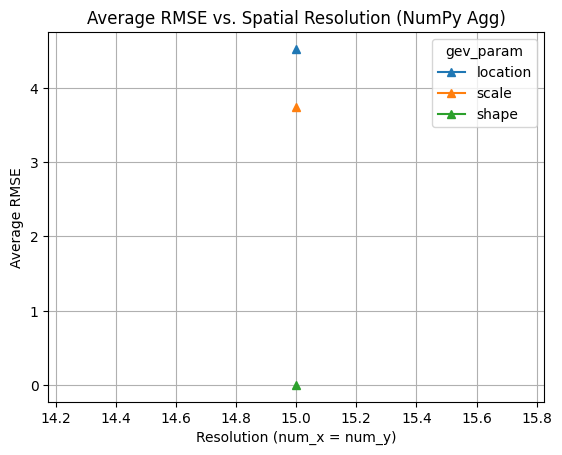

In [64]:
# --- Example: Accessing specific data ---
if 'rmse' in sweep_results_multi and 'res' in sweep_results_multi.coords:
    try:
        print("\n--- RMSE for Scale Parameter vs. Resolution ---")
        print(sweep_results_multi['rmse'].sel(gev_param='scale'))

        # --- Example: Plotting (requires matplotlib) ---
        import matplotlib.pyplot as plt

        # Plot nRMSE vs resolution for each GEV parameter
        nrmse_data = sweep_results_multi['rmse']
        nrmse_data.plot.line(x='res', hue='gev_param', marker='^') # Use different marker
        plt.title('Average RMSE vs. Spatial Resolution (NumPy Agg)')
        plt.xlabel('Resolution (num_x = num_y)')
        plt.ylabel('Average RMSE')
        plt.grid(True)
        plt.show()

    except ImportError:
        print("\nMatplotlib not installed. Skipping plot example.")
    except Exception as plot_e:
        print(f"\nError during plotting: {plot_e}")

In [65]:
sweep_results_multi.sel(res=15)

<xarray.Dataset> Size: 172B
Dimensions:    (gev_param: 3)
Coordinates:
    res        int32 4B 15
  * gev_param  (gev_param) <U8 96B 'location' 'scale' 'shape'
Data variables:
    bias       (gev_param) float64 24B 0.01811 0.001366 0.0001356
    rmse       (gev_param) float64 24B 4.524 3.741 0.004125
    sd         (gev_param) float64 24B 4.523 3.74 1.915e-17
Attributes:
    description:             Aggregated simulation sweep results (multi-trend...
    simulation_function:     run_simulation_raw
    trend_config_structure:  dict_keys(['location', 'scale'])
    aggregation_function:    mean
    sweep_parameters:        ['res']
    base_config_used:        True

In [8]:
import pickle
from pathlib import Path

output_folder = Path("./simulation_output")
# Use a common extension for pickled files, like .pkl or .pickle
file_name = "sim2.pkl"
output_path = output_folder / file_name

# --- Ensure Output Folder Exists ---
output_folder.mkdir(parents=True, exist_ok=True)

# --- Save the xarray Dataset using pickle ---
try:
    # Open the file in binary write mode ('wb')
    with open(output_path, 'wb') as f:
        pickle.dump(sweep_results_multi, f)
    print(f"Successfully saved (pickled) Dataset object to: {output_path}")
except Exception as e:
    print(f"Error saving (pickling) Dataset to {output_path}: {e}")

Error saving (pickling) Dataset to simulation_output\sim2.pkl: name 'sweep_results_multi' is not defined


In [16]:
import pickle
from pathlib import Path
output_folder = Path("./simulation_output")
file_name = "sim4.pkl"
output_path = output_folder / file_name

try:
    # Open the file in binary read mode ('rb')
    with open(output_path, 'rb') as f:
        loaded_ds = pickle.load(f)
    print(f"\nSuccessfully loaded (unpickled) Dataset object from: {output_path}")
    print("\nLoaded Dataset:")
    print(loaded_ds)
    print("\nChecking boolean attribute:")
    print(f"loaded_ds.attrs['base_config_used'] = {loaded_ds.attrs['base_config_used']} (Type: {type(loaded_ds.attrs['base_config_used'])})")
    print("\nChecking list attribute:")
    print(f"loaded_ds.attrs['some_list'] = {loaded_ds.attrs['some_list']} (Type: {type(loaded_ds.attrs['some_list'])})")

except FileNotFoundError:
    print(f"\nError: File not found at {output_path}")
except Exception as e:
    print(f"\nError loading (unpickling) Dataset from {output_path}: {e}")
    loaded_ds


Successfully loaded (unpickled) Dataset object from: simulation_output\sim4.pkl

Loaded Dataset:
<xarray.Dataset> Size: 552B
Dimensions:            (res: 6, gev_param: 3)
Coordinates:
  * res                (res) int32 24B 2 3 5 10 15 20
  * gev_param          (gev_param) <U8 96B 'location' 'scale' 'shape'
Data variables:
    bias               (res, gev_param) float64 144B 0.648 -0.648 ... -0.0004099
    rmse               (res, gev_param) float64 144B 4.843 3.728 ... 0.002604
    variance_of_error  (res, gev_param) float64 144B 16.74 8.599 ... 6.053e-31
Attributes:
    description:             Aggregated simulation sweep results (multi-trend...
    simulation_function:     run_simulation_raw
    trend_config_structure:  dict_keys(['location', 'scale', 'shape'])
    aggregation_function:    nanmedian
    sweep_parameters:        ['res']
    base_config_used:        True

Checking boolean attribute:
loaded_ds.attrs['base_config_used'] = True (Type: <class 'bool'>)

Checking list attri

In [17]:
output_path = output_folder / file_name

try:
    # Open the file in binary read mode ('rb')
    with open(output_path, 'rb') as f:
        loaded_ds = pickle.load(f)
    print(f"\nSuccessfully loaded (unpickled) Dataset object from: {output_path}")
    print("\nLoaded Dataset:")
    print(loaded_ds)
    print("\nChecking boolean attribute:")
    print(f"loaded_ds.attrs['base_config_used'] = {loaded_ds.attrs['base_config_used']} (Type: {type(loaded_ds.attrs['base_config_used'])})")
    print("\nChecking list attribute:")
    print(f"loaded_ds.attrs['some_list'] = {loaded_ds.attrs['some_list']} (Type: {type(loaded_ds.attrs['some_list'])})")

except FileNotFoundError:
    print(f"\nError: File not found at {output_path}")
except Exception as e:
    print(f"\nError loading (unpickling) Dataset from {output_path}: {e}")
    loaded_ds


Successfully loaded (unpickled) Dataset object from: simulation_output\sim4.pkl

Loaded Dataset:
<xarray.Dataset> Size: 552B
Dimensions:            (res: 6, gev_param: 3)
Coordinates:
  * res                (res) int32 24B 2 3 5 10 15 20
  * gev_param          (gev_param) <U8 96B 'location' 'scale' 'shape'
Data variables:
    bias               (res, gev_param) float64 144B 0.648 -0.648 ... -0.0004099
    rmse               (res, gev_param) float64 144B 4.843 3.728 ... 0.002604
    variance_of_error  (res, gev_param) float64 144B 16.74 8.599 ... 6.053e-31
Attributes:
    description:             Aggregated simulation sweep results (multi-trend...
    simulation_function:     run_simulation_raw
    trend_config_structure:  dict_keys(['location', 'scale', 'shape'])
    aggregation_function:    nanmedian
    sweep_parameters:        ['res']
    base_config_used:        True

Checking boolean attribute:
loaded_ds.attrs['base_config_used'] = True (Type: <class 'bool'>)

Checking list attri

In [19]:
loaded_ds.sel(res=15)

<xarray.Dataset> Size: 172B
Dimensions:            (gev_param: 3)
Coordinates:
    res                int32 4B 15
  * gev_param          (gev_param) <U8 96B 'location' 'scale' 'shape'
Data variables:
    bias               (gev_param) float64 24B -0.002411 -0.0255 0.0004545
    rmse               (gev_param) float64 24B 0.6351 0.4723 0.003879
    variance_of_error  (gev_param) float64 24B 0.2605 0.152 3.61e-31
Attributes:
    description:             Aggregated simulation sweep results (multi-trend...
    simulation_function:     run_simulation_raw
    trend_config_structure:  dict_keys(['location', 'scale', 'shape'])
    aggregation_function:    nanmedian
    sweep_parameters:        ['res']
    base_config_used:        True